# Reinforcement Learning 
In this last programming assignment, you'll be writing a code that will teach your computers how to operate a Taxi. A taxi's task is to pick up a passenger at one location and drop him/her off somewhere else. This task is considered successful when the taxi 1) drops off the passenger in the correct location 2) doesn't take a long time to reach destination 3) doesn't perform any illegal pickups or dropoffs during the trip. 

We will be using the gym library for this problem. First let's install the library. 

In [91]:
# Package imports
import matplotlib
import matplotlib.pyplot as plt
from random import randint

# Display plots inline and change default figure size 
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Command to install gym, DO NOT CHANGE
import sys
!{sys.executable} -m pip install gym

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The Taxi-v1 problem in openai/gym is defined by a grid defined over 25 squares. This grid has 4 locations designated by 4 letters: R(red), B(blue), G(green) and Y(yellow). This problem is episodic where in each episode the passenger is in one of the four locations and wishes to be transported to one of the four locations (pickup and dropoff locations are chosen randomly). The episode ends when the passenger is deposited at the destination location. The taxi is supposed to operate in the environment without hitting the walls however is not heavily penalized for that (doesn't work this way in real life but it is just an example). 

    +---------+
    |R: | : :G|
    | : : : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+

The reward system of this problem is defined as follows
* Successful dropoff: +20 points
* -1 point for every action taken (including one that results in hitting the wall) 
* Illegal pickup/dropoff: -10 points

Openai uses some colors to help better render the grid. The rendering colors are explained below: 
* blue: passenger
* magenta: destination
* yellow: empty taxi
* green: full taxi

In [92]:
# Importing the libraries needed for our problem
import gym
import numpy as np

## Creating the environment
Now we can create our environment by simply running the commands given below. When you run the env.reset() command, you'll see the task we will be working on in this homework. 

In [93]:
# Create the environment 
env = gym.make('Taxi-v2')
env.reset()
env.render() 

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## About the gym interface
There are three main operations that you can execute in this environment. We already used two of them

* __env.reset()__ : resets the environment to its initial state. It returns an initial observation
* __env.render()__ : outputs the current state of the environment
* __env.step(action)__ : performs an action and returns 4 values 
 * _observation_ : an object to represent your environment
 * _reward_ : reward gained from performing the last action
 * _done_ : True of false for whether the environment finished its tasks or not. 
 * _info_ : Extra information that you don't have to worry about for now. 
 
For further information about gym, please consider checking their website https://gym.openai.com/
 
The space of observations and actions in gym is already defined. Run the next commands to discover how these spaces look like in this problem. 

In [94]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

('Observation space:', Discrete(500))
('Action space:', Discrete(6))


As you can see, there are 500 states and 6 actions in your environment.

Play around with all possible actions (i.e. 0 through 5)

In [95]:
# TODO: experiment with the six actions in the env.action_space.
# (i.e.  just run each action and then render to show the result)
# Hint: env.step(action_number) performs an action.
#       env.render() shows the current state


print(env.step(0))
env.render()

(204, -1, False, {'prob': 1.0})
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


Briefly explain what you saw in your experiment AND how we ended up with 500 states

Action Space:
0 moves south   2 moves east   4 says pickup
1 moves north   3 moves west   5 says drop off

Environment:
The grid is 5x5, there is a state where the passengers are in each of the 4 locations pickup and where they're inside of the taxis, and there are 4 passenger locations. Therefore, the number of states is 5 * 5 * (4 + 1) * 4 = 500
env.step() returns 
    observation: Observations of the environment
    reward: If your action was beneficial or not
    done: Indicates if we have successfully picked up and dropped off a passenger
    info: Additional info such as performance and latency for debugging purposes

Rules:
Yellow = no passenger, Green = passenger
Purple = current pickup, Blue = current dropoff

## Play time
As a first introduction to this problem, try to run 1000 random steps. You're not expected to do Q-learning while doing that. Just run through the game :)

In [96]:
def plotRewardsAndGains(iterations, rewards, gains):
    matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
    plt.figure(1)
    
    plt.subplot(121)
    plt.plot(iterations, rewards, 'x');
    plt.xlabel('iterations'); plt.ylabel('rewards');
    
    plt.subplot(122)
    plt.plot(iterations, gains);
    plt.xlabel('iterations'); plt.ylabel('gain');

    plt.show();

('Rewards:', [-1, -1, -1, -1, -1, -1, -1, -10, -1, -10, -10, -10, -1, -1, -1, -1, -1, -10, -1, -1, -1, -1, -1, -1, -1, -1, -10, -1, -1, -1, -1, -1, -10, -1, -1, -10, -10, -1, -1, -1, -10, -1, -10, -1, -1, -1, -1, -10, -1, -10, -1, -1, -10, -10, -10, -1, -1, -1, -1, -10, -1, -1, -1, -10, -1, -1, -1, -10, -1, -10, -1, -10, -1, -1, -1, -1, -1, -10, -10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -10, -1, -1])
('Gains:', [-1, -2, -3, -4, -5, -6, -7, -17, -18, -28, -38, -48, -49, -50, -51, -52, -53, -63, -64, -65, -66, -67, -68, -69, -70, -71, -81, -82, -83, -84, -85, -86, -96, -97, -98, -108, -118, -119, -120, -121, -131, -132, -142, -143, -144, -145, -146, -156, -157, -167, -168, -169, -179, -189, -199, -200, -201, -202, -203, -213, -214, -215, -216, -226, -227, -228, -229, -239, -240, -250, -251, -261, -262, -263, -264, -265, -266, -276, -286, -287, -288, -289, -290, -291, -292, -293, -294, -295, -296, -297, -298, -299, -300, -301, -302, -303, -304, -314, -31

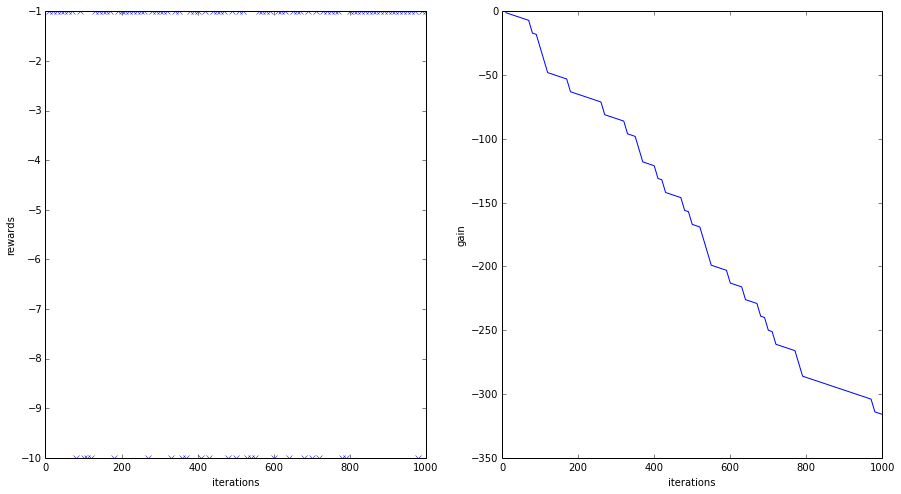

In [100]:
gains = list();            # to collect total rewards (gains)
rewards = list();          # to collect immediate rewards
iterations = list();       # to collect iterations

state = env.reset()        # resets the environment and returns an initial state
gain, reward = 0, 0     

# TODO - BEGIN: run a thousand steps. Every 10th step, record the 
# iteration number, current reward, and current sum of rewards 
# (gain) in the above defined lists.
for i in range(1, 1001):
    state, reward, done, info = env.step(randint(0, 5))
    gain += reward
    if (i%10 == 0):
        iterations.append(i)
        rewards.append(reward)
        gain = sum(rewards)
        gains.append(gain)

# TODO - END
env.reset()

# print the rewards and gains across iterations
print("Rewards:", rewards)
print("Gains:", gains)
plotRewardsAndGains(iterations, rewards, gains);

## Training using Q-Learning

We will try to train our model using the Q-Learning algorithm which you saw in class. The goal of this algorithm is to learn a policy that decides which actions to take next. 
We first start with setting up the problem. 

Perform the necessary initializations for the problem (hint: initialize the Q matrix and reset the environment)

In [98]:
state = env.reset()
Q = np.zeros([env.observation_space.n, env.action_space.n])

The heart of Q-Learning relies on updating the Q-values of the best policy. This is calculated using the weighted average of the old Q-value and the new information. Write a function that performs this operation for only one entry in the Q-matrix (that is for one state and one action). The input of the function is not given, however it needs to return a new value for Q(state, action) at a certain iteration. (Hint: this formula is based on Bellman equation and was discussed in class) 

In [101]:
def compute_q_sample(Q, currState, currAction, newState, reward, lr, discount):
    """
        Input:
            Q          : a SxA matrix, where S is the number of states and A is the number of actions
            currState  : the current state
            currAction : the current action taken
            newState   : the new state resulting from 'currAction' on 'currState'
            reward     : the immediate reward
            lr         : the learning rate
            discount   : the discount factor
            
        Output:
            The sample value for updating Q. Look at the Q-learning algorithm discussed in class 
    """

    val = 0;
    
    # TODO: Implement your code here
    val = lr * (reward + discount * (np.max(Q[newState]) - Q[currState, currAction]))
    return val;
    

The function you just implemented only updates one cell in the Q-matrix. In the Q-learning algorithm, you'll need to "solve" the problem for each episode. "Solve" is loosely defined here to indicate reaching an end state. For instance the Taxi problem reaches an end state when the passenger is dropped off however solving the problem means getting an average reward of 9.6 over 100 consecutive trials. 

Your next task is to implement one episode of this problem. The episode has the following steps
* Start from an initial state
* While game not done
 * Greedily select one action 
 * Using this action, go to the next state
 * Compute Q(state, action) 
 * Update the state and total gain


In [103]:
def RunSingleQLearningEpisode(Q, env):
    """ Run Q-learning on a single episode and update the Q-table

        Input:
            Q     : a SxA matrix, where S is the number of states and A is the number of actions
            env   : the RL environment 
            
        Output:
            [gain, finalState] 
                A tuple containing the total gain (sum of rewards) and the final state reached
    """
    
    state = env.reset()
    gain = 0
    FinalState = None
    done = False
    learning_rate = 0.6
    discount = 0.9
    
    # TODO: Your code here
    while(not done):
        action = np.argmax(Q[state])
        newState, reward, done, info = env.step(action)
        Q[state, action] += compute_q_sample(Q, state, action, newState, reward, learning_rate, discount)
        gain += reward
        state = newState
    
    finalState = state
    return [gain, finalState];


Now, we're ready to run this episode many times to teach our agent what the optimal policy would be. Train your algorithm for 10000 iterations and print the total gain every 100 steps. 

In [105]:
state = env.reset()
counter = 0
reward = None

gains = list();
epochs = list();

Q = np.zeros([env.observation_space.n, env.action_space.n])

# TODO: Implement your code here. Run the above function 'RunSingleQLearningEpisode' 10000 times on Q.
# Every 100 times, print the total reward and render the environment.
# Also, every 100 times, add the iteration number to 'epochs' and the total reward of that iteration to 'gains'
for i in range(1, 10001):
    gain, state = RunSingleQLearningEpisode(Q, env)
    if i % 100 == 0:
        print(gain)
        env.render()
        epochs.append(i)
        gains.append(gain)

-123
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
-121
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
9
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
9
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
7
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
10
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
6
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
5
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
11
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
8
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
10
+--------

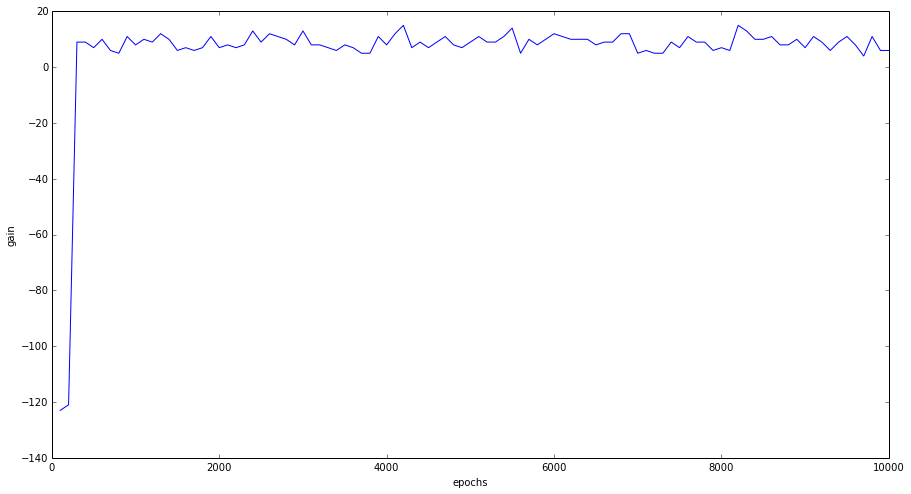

In [106]:
plt.plot(epochs, gains);
plt.xlabel('epochs');
plt.ylabel('gain')
plt.show()

The Q-Learning algorithm converges to the optimal policy. This means that using the Q matrix, you're expected to find the optimal policy for any starting state. Your final task is to find the optimal policy a random starting state. Print the state, sequence of actions and the final total gain. Comment on the result using plain English

In [109]:

def PlaySingleGame(Q, env):
    """ Run Q-learning on a single episode and update the Q-table

        Input:
            Q     : a SxA matrix, where S is the number of states and A is the number of actions
            env   : the RL environment 
    """
    
    currState = env.reset()
    totalGain = 0;               # total gain accumulated across game
    
    # show initial state
    env.render()

    # TODO: Run a game from start to end. Print the action taken at each step
    done = False
    while not done:
        action = np.argmax(Q[currState])
        newState, reward, done, info = env.step(action)
        totalGain += reward
        print(action)
        env.render()
        currState = newState
    
    
    # show final state
    env.render()    
    print "Total Gain = ", totalGain
    

In [110]:
PlaySingleGame(Q,env)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

2
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
1
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
2
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
1
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
4
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
0
+---------+
|R: | : :G|
| : : : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
3
+---------+
|R: | : :G|
| : : :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
3
+---------+
|R: | : :G|
| : :_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
3
+---------+
|R: | : :G|
| :_: : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
3
+---------+
|R: | : :G|
|_: : : : |
| : : : : |
| | :

Result discussion goes here.

The algorithm takes the most direct path to the pickup location, picks up the passenger, and then takes the most direct route to the drop off location to drop the passenger off. This task is completed successfully! The dropoff prints twice because there are 2 env.render() calls - one when the loop ends and one at the very end of the method. The total gain is 9 and there were 13 steps taken, so not every step resulted in a successful reward, but it turns out positive!